In [36]:
from worldcereal.openeo.feature_extractor import extract_presto_embeddings
from worldcereal.job import create_embeddings_process_graph
from worldcereal.parameters import EmbeddingsParameters
import xarray as xr
import matplotlib.pyplot as plt


ONNX_DEPS_URL = "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/onnx_deps_python311.zip"
FEATURE_DEPS_URL = "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/torch_deps_python311.zip"


In [35]:
preprocessed_inputs = "/vitodata/worldcereal/data/COP4GEOGLAM/moldova/preprocessed_inputs_newimage/PSU_ID_46/preprocessed-inputs_2024-09-01_2025-08-31_PSU_ID_46.nc"  # with the fix for S1 shift
epsg = 32635
presto_model_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/Copernicus4Geoglam/presto-prometheo-cop4geoglam-run-with-AL-and-freezing-month-LANDCOVER10-augment%3DFalse-balance%3DTrue-timeexplicit%3DFalse-run%3D202509041943_encoder.pt"

embedding_params = EmbeddingsParameters()
embedding_params = embedding_params.feature_parameters.model_dump()
embedding_params.update({"ignore_dependencies": True})
embedding_params["presto_model_url"] = presto_model_url

### Local run

In [6]:
ds = xr.open_dataset(preprocessed_inputs)
# ds = ds.fillna(NODATAVALUE)  # SHOULD NOT DO THIS AS IN OPENEO THE ARRAY IS FLOAT32 AND CONTAINING NAN AT THIS POINT!
arr = ds.drop_vars("crs").to_array(dim="bands")



embeddings = extract_presto_embeddings(
    inarr=arr, parameters=embedding_params, epsg=epsg
)

INFO:worldcereal.openeo.feature_extractor:Loading Presto model from "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/Copernicus4Geoglam/presto-prometheo-cop4geoglam-run-with-AL-and-freezing-month-LANDCOVER10-augment%3DFalse-balance%3DTrue-timeexplicit%3DFalse-run%3D202509041943_encoder.pt"
INFO:worldcereal.openeo.feature_extractor:Loading Prometheo wheel from "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/dependencies/prometheo-0.0.2-py3-none-any.whl"
INFO:worldcereal.openeo.feature_extractor:`ignore_dependencies` flag is set to True. Make sure that Presto and its dependencies are available on the runtime environment
INFO:worldcereal.openeo.feature_extractor:Band names: B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12, VH, VV, slope, elevation, total_precipitation, temperature_2m
INFO:worldcereal.openeo.feature_extractor:Array dtype: float32, Array size: (16, 12, 50, 50), total pixels: 480000, Pixel statistics: NaN pixels = 40000 (8.33%), 0 pixe

Text(0.5, 1.0, 'First axis of the embeddings')

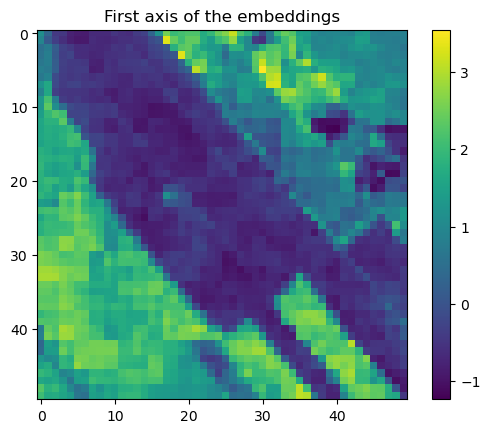

In [11]:
plt.imshow(embeddings.values[0,:,:])
plt.colorbar()
plt.title('First axis of the embeddings')

### OpenEO run

In [39]:
from openeo_gfmap import BoundingBoxExtent, TemporalContext

temporal_extent = TemporalContext(start_date="2024-09-01", end_date="2025-08-31")  # Matchig how preprocessed inputs were generated
spatial_extent = BoundingBoxExtent(*(641510.0, 5304240.0, 642010.0, 5304740.0), epsg=epsg)

inference_result = create_embeddings_process_graph(
        spatial_extent=spatial_extent,
        temporal_extent=temporal_extent,
        embeddings_parameters=EmbeddingsParameters(
            feature_parameters=embedding_params,
        ),
        s1_orbit_state="DESCENDING",  # Same as used in preprocessed inputs
        target_epsg=None,
    )

# Submit the job
job_options = {
    "driver-memory": "4g",
    "executor-memory": "2g",
    "executor-memoryOverhead": "1g",
    "python-memory": "3g",
    "soft-errors": 0.1,
    # "image-name": "python311",
    "image-name": "registry.dev.internal/dev/openeo-geotrellis-kube-python311:20250905-136",  # With the fix for S1 shift
    "max-executors": 10,
    "udf-dependency-archives": [
        f"{ONNX_DEPS_URL}#onnx_deps",
        f"{FEATURE_DEPS_URL}#feature_deps",
    ],
}

job = inference_result.create_job(
    title="WorldCereal embeddings generator for debugging",
    job_options=job_options,
)

job.start_and_wait()

for asset in job.get_results().get_assets():
    if asset.metadata["type"].startswith("image/tiff"):
        asset.download("./downloaded_embeddings.tif")
        break

INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.
0:00:00 Job 'j-25090807321740e59d598a0bd72fa586': send 'start'
0:00:13 Job 'j-25090807321740e59d598a0bd72fa586': created (progress 0%)
0:00:19 Job 'j-25090807321740e59d598a0bd72fa586': created (progress 0%)
0:00:25 Job 'j-25090807321740e59d598a0bd72fa586': created (progress 0%)
0:00:33 Job 'j-25090807321740e59d598a0bd72fa586': created (progress 0%)
0:00:43 Job 'j-25090807321740e59d598a0bd72fa586': created (progress 0%)
0:00:55 Job 'j-25090807321740e59d598a0bd72fa586': queued (progress 0%)
0:01:11 Job 'j-25090807321740e59d598a0bd72fa586': queued (progress 0%)
0:01:30 Job 'j-25090807321740e59d598a0bd72fa586': queued (progress 0%)
0:01:54 Job 'j-25090807321740e59d598a0bd72fa586': queued (progress 0%)
0:02:24 Job 'j-25090807321740e59d598a0bd72fa586': running (progress N/A)
0:03:01 Job 'j-25090807321740e59d598a0bd72fa586': running (progress N/A)
0:03:48 Job 'j-25090807321740e59d598a0bd72fa586': running (progress N/A)
0:04:46 Job 'j-25090807321740e59d598a0b

INFO:openeo.rest.job:Downloading Job result asset 'embeddings_2024-09-01_2025-08-31.tif' from https://s3.waw3-1.openeo.v1.dataspace.copernicus.eu/openeo-data-prod-waw4-1/batch_jobs/j-25090807321740e59d598a0bd72fa586/embeddings_2024-09-01_2025-08-31.tif?X-Proxy-Head-As-Get=true&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=8d9f65c3de324084a6d569feaf093400%2F20250908%2Fwaw4-1%2Fs3%2Faws4_request&X-Amz-Date=20250908T074406Z&X-Amz-Expires=86400&X-Amz-SignedHeaders=host&X-Amz-Security-Token=eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCJ9.eyJyb2xlX2FybiI6ImFybjpvcGVuZW93czppYW06Ojpyb2xlL29wZW5lby1kYXRhLXByb2Qtd2F3NC0xLXdvcmtzcGFjZSIsImluaXRpYWxfaXNzdWVyIjoib3BlbmVvLnByb2Qud2F3My0xLm9wZW5lby1pbnQudjEuZGF0YXNwYWNlLmNvcGVybmljdXMuZXUiLCJodHRwczovL2F3cy5hbWF6b24uY29tL3RhZ3MiOnsicHJpbmNpcGFsX3RhZ3MiOnsiam9iX2lkIjpbImotMjUwOTA4MDczMjE3NDBlNTlkNTk4YTBiZDcyZmE1ODYiXSwidXNlcl9pZCI6WyI0ZmQ5ZGI5Ni1kNjIwLTQ0NTQtOWJlNi0xNGE3ZDhlOTIzNTciXX0sInRyYW5zaXRpdmVfdGFnX2tleXMiOlsidXNlcl9pZCIsImpvYl9pZCJdfSwiaXNzIjoic3Rz

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


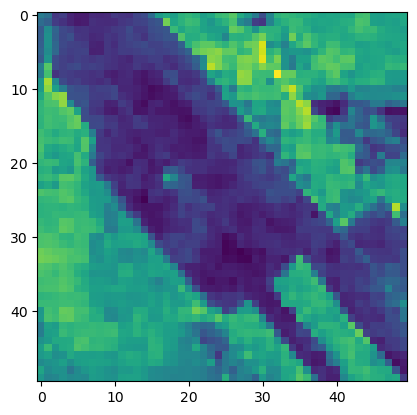

In [45]:
import rasterio
openeo_embeddings = rasterio.open("./downloaded_embeddings.tif").read()
plt.imshow(openeo_embeddings[0,:,:])

### Comparison

Text(0.5, 1.0, 'Difference')

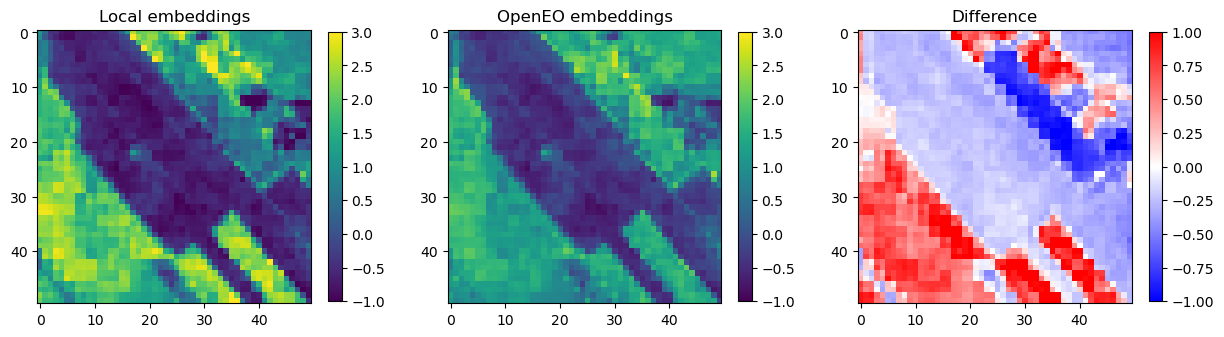

In [57]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
img0 = ax[0].imshow(embeddings.values[0,:,:], vmin=-1, vmax=3)
f.colorbar(img0, ax=ax[0], shrink=0.7)
ax[0].set_title('Local embeddings')

img1 = ax[1].imshow(openeo_embeddings[0,:,:], vmin=-1, vmax=3)
f.colorbar(img1, ax=ax[1], shrink=0.7)
ax[1].set_title('OpenEO embeddings')

diff_img = ax[2].imshow(embeddings.values[0,:,:] - openeo_embeddings[0,:,:], cmap='bwr', vmin=-1, vmax=1)
f.colorbar(diff_img, ax=ax[2], shrink=0.7)
ax[2].set_title('Difference')